In [1]:
import tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [2]:
tweets = pd.read_csv('./Tweets.csv',sep=',')
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
data = tweets[['text','airline_sentiment']]
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|([^a-zA-z0-9\s])','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

4726
18356


In [4]:
max_features = 4000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [5]:
embed_dim = 210
lstm_out = 270

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 210)           840000    
_________________________________________________________________
dropout (Dropout)            (None, 33, 210)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 270)               519480    
_________________________________________________________________
dense (Dense)                (None, 2)                 542       
Total params: 1,360,022
Trainable params: 1,360,022
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7732, 33) (7732, 2)
(3809, 33) (3809, 2)


In [7]:
X_val = X_train[:500]
Y_val = Y_train[:500]

In [8]:
partial_X_train = X_train[500:]
partial_Y_train = Y_train[500:]

In [9]:
batch_size = 256

history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

C:\Users\hp\AppData\Local\conda\conda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7232 samples, validate on 500 samples
Epoch 1/10
7232/7232 [==============================] - 36s 5ms/step - loss: 0.4765 - acc: 0.8035 - val_loss: 0.3524 - val_acc: 0.8340
Epoch 2/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.2866 - acc: 0.8782 - val_loss: 0.2117 - val_acc: 0.9200
Epoch 3/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.1772 - acc: 0.9299 - val_loss: 0.1781 - val_acc: 0.9340
Epoch 4/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.1304 - acc: 0.9508 - val_loss: 0.1699 - val_acc: 0.9420
Epoch 5/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.0995 - acc: 0.9620 - val_loss: 0.1922 - val_acc: 0.9260
Epoch 6/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.0865 - acc: 0.9694 - val_loss: 0.1987 - val_acc: 0.9240
Epoch 7/10
7232/7232 [==============================] - 9s 1ms/step - loss: 0.0803 - acc: 0.9715 - val_loss: 0.2125 - val_acc: 0.9320
Epoch 8/10
723

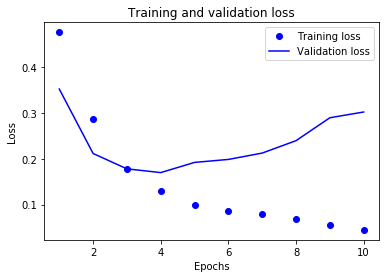

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

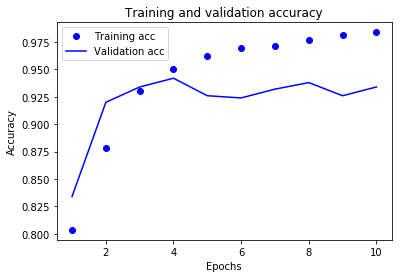

In [11]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 82.0754716981132 %
neg_acc 96.44670050761421 %
